In [2]:
pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e3/f8/9246d3c7e185a29d7359d8b12b3d70bf2c3150ecf1427ec1382290e71a56/tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/8f/aa/ba0014cc4659328dc818a28827be78e6d97312ab0cb98105a770924dc11e/absl_py-2.3.1-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=24.3.25 from https://files.pythonhosted.org/packages/ee/1b/00a78aa2e8fbd63f9af08c9c19e6deb3d5d66b4dda677a0f61654680ee89/flatbuffers-25.9.23-py2.py3-none-any.whl.metadata
  Obtaining dependency information for gast!=0.5.0,!=0.5.1,!=0.5.2,>=0.2.1 from https://files.pythonhosted.org/packages/a3/61/8001b38461d751c


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, EfficientNetV2B0

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Set a consistent random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Helper function to plot t-SNE
def plot_tsne(tsne_results, labels, title):
    """Plots t-SNE results with colored labels."""
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, 
                          cmap='tab10', alpha=0.7, s=10)
    plt.legend(handles=scatter.legend_elements()[0], labels=list(range(10)), 
               title="Digits")
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

def report_metrics(y_true, y_pred, model_name):
    """Prints accuracy, F1-score, and plots a confusion matrix."""
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"\n--- Metrics for {model_name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return acc, f1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import tensorflow.keras as keras # Use tensorflow.keras to load data
import numpy as np
import time
import copy # Needed for saving the best model state

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Load MNIST Data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# 2. Preprocess Data for MLP/RF/LR (Flatten and Normalize)
# Normalize to [0, 1]
x_train_flat = x_train.reshape(60000, 784).astype('float32') / 255.0
x_test_flat = x_test.reshape(10000, 784).astype('float32') / 255.0

# --- Train Logistic Regression (Faster) ---
print("\nTraining Logistic Regression (Saga, faster tolerance)...") 
start_time_lr = time.time() 

lr_model = LogisticRegression(
    solver='saga',
    max_iter=1000,           
    tol=1e-3,                
    random_state=42,
    n_jobs=-1
)

lr_model.fit(x_train_flat, y_train)

print(f"Logistic Regression trained in {(time.time() - start_time_lr):.2f}s")
print(f"Saga stopped after {lr_model.n_iter_[0]} iterations.")

y_pred_lr = lr_model.predict(x_test_flat)
report_metrics(y_test, y_pred_lr, "Logistic Regression (Saga, tol=1e-3)")

# --- Train Random Forest ---
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1
)
rf_model.fit(x_train_flat, y_train)
y_pred_rf = rf_model.predict(x_test_flat)
report_metrics(y_test, y_pred_rf, "Random Forest (n=100)")

# --- Define and Train MLP (PyTorch Implementation) ---

class MLP_PyTorch(nn.Module):
    def __init__(self):
        super(MLP_PyTorch, self).__init__()
        self.layer1 = nn.Linear(784, 30)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(30, 20)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(20, 10)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x_out = self.output_layer(x)
        return x_out

# --- 2. Prepare Data for PyTorch ---
x_train_tensor = torch.tensor(x_train_flat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_flat, dtype=torch.float32)

batch_size = 64
full_train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)

# --- 3. Initialize Model, Loss, and Optimizer ---
print("\nTraining MLP (PyTorch with Early Stopping)...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

pt_model = MLP_PyTorch().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pt_model.parameters())

# --- 4. PyTorch Training Loop with Early Stopping ---
num_epochs = 100
patience = 5
patience_counter = 0
best_val_loss = float('inf')
best_model_state = None

start_time = time.time()

for epoch in range(num_epochs):
    # --- Training Pass ---
    pt_model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = pt_model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)

    # --- Validation Pass ---
    pt_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val = inputs_val.to(device)
            labels_val = labels_val.to(device)
            
            outputs_val = pt_model(inputs_val)
            val_loss = criterion(outputs_val, labels_val)
            running_val_loss += val_loss.item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    
    if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # --- Early Stopping Check ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = copy.deepcopy(pt_model.state_dict())
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}!")
        break 

print(f"Finished Training. Total time: {(time.time() - start_time):.2f}s")

# --- 5. Evaluate the PyTorch Model ---
if best_model_state:
    print(f"Loading best model state with val loss: {best_val_loss:.4f}")
    pt_model.load_state_dict(best_model_state)
else:
    print("Warning: Early stopping did not find a best model. Using last model state.")

pt_model.eval() 
x_test_tensor_gpu = x_test_tensor.to(device)

with torch.no_grad():
    y_prob_mlp_pt = pt_model(x_test_tensor_gpu)

y_prob_mlp_pt_cpu = y_prob_mlp_pt.cpu().numpy()
y_pred_mlp_pt = np.argmax(y_prob_mlp_pt_cpu, axis=1)

report_metrics(y_test, y_pred_mlp_pt, "MLP (30, 20) [PyTorch w/ Early Stop]")


Training Logistic Regression (Saga, faster tolerance)...
Logistic Regression trained in 233.64s
Saga stopped after 209 iterations.

--- Metrics for Logistic Regression (Saga, tol=1e-3) ---
Accuracy: 0.9257
F1-Score (Weighted): 0.9255



Training Random Forest...

--- Metrics for Random Forest (n=100) ---
Accuracy: 0.9704
F1-Score (Weighted): 0.9704



Training MLP (PyTorch with Early Stopping)...
Using device: cpu
Epoch [10/100], Train Loss: 0.0903, Val Loss: 0.1407
Early stopping triggered at epoch 19!
Finished Training. Total time: 43.79s
Loading best model state with val loss: 0.1342

--- Metrics for MLP (30, 20) [PyTorch w/ Early Stop] ---
Accuracy: 0.9664
F1-Score (Weighted): 0.9664


(0.9664, 0.9663616647181199)

### **Observations**
From the results, the Random Forest achieved the highest accuracy (0.9704), followed closely by the MLP (0.9664), while Logistic Regression lagged behind at 0.9257.

##### **1. Logistic Regression:**
The logistic regression model, being linear, struggled to capture the non-linear relationships within pixel intensities. Its confusion matrix showed widely distributed off-diagonal values, indicating poor class separation. The long training time is due to the iterative optimization used by the Saga solver. Overall, it failed to generalize complex shapes and curves in handwritten digits.

##### **2. Random Forest:**
The random forest performed the best among the three. Its confusion matrix was sharply diagonal, showing highly accurate predictions. The ensemble approach helped it create complex, non-linear decision boundaries, allowing the model to recognize variations in handwriting styles effectively. Errors were rare and typically occurred only between digits that look similar to the human eye.

##### 3. **MLP (30–20–10):**
The MLP performed almost as well as the Random Forest while training efficiently (43.79s). The model learned strong non-linear representations and achieved high precision. Early stopping helped prevent overfitting, leading to stable performance. Its minor difference from the Random Forest suggests that even a relatively shallow MLP can learn effective feature representations from pixel data.

Overall, the hierarchy of model performance is:

Random Forest > MLP > Logistic Regression.

The Random Forest’s slight edge over the MLP likely arises from better hyperparameter tuning and the MLP’s shallow architecture. A deeper MLP or CNN could surpass the Random Forest due to their ability to learn spatial relationships directly from image data.

### **Misclassification Analysis**

A detailed look at the confusion matrices reveals distinct patterns of errors across the three models.

##### **1. Logistic Regression:**
The misclassifications were numerous and scattered, showing the model’s weak boundary separation. The most common confusions occurred between digits with similar shapes:

‘5’ misclassified as ‘3’ (35 times)

‘2’ as ‘8’ (34 times)

‘7’ as ‘9’ (33 times)

‘4’ as ‘9’ (31 times)

These mistakes show that the model failed to capture curved or intersecting features - for instance, the circular part of a ‘5’ being mistaken for a ‘3’, or the top loops of ‘2’ and ‘8’ appearing similar in certain handwriting styles.

##### **2. Random Forest:**
The Random Forest made very few errors, with misclassifications primarily limited to pairs of digits that are visually similar. The most common error was:

‘7’ misclassified as ‘2’ (20 instances), likely because both share a similar upper horizontal stroke.

A smaller number of mutual errors were observed between ‘4’ and ‘9’, as the loop and stem in handwritten forms can overlap visually. Unlike Logistic Regression, which is a linear model and limited to drawing straight-line decision boundaries, the Random Forest is non-linear and capable of capturing complex feature interactions between pixels. Hence, the few errors it made were not due to poor generalization but rather the inherent visual ambiguity in certain digits that even powerful non-linear models can find difficult to distinguish perfectly.


##### **3. MLP:**
The MLP’s misclassification pattern closely resembled human perception errors - it confused digits that look alike rather than making random mistakes. The most frequent were:

‘9’ as ‘4’ (19 instances)

‘7’ as ‘2’ (13 instances)

Mutual confusion between ‘3’ and ‘5’ (11 and 12 instances respectively)

These misclassifications occurred because the MLP, though capable of learning non-linear patterns, still processes the input as a flat vector of 784 pixels, ignoring spatial relationships. Also, since our MLP was shallow with fewer layers, it couldn’t fully learn the complex variations in digit shapes. Hence, digits with similar strokes but slightly different positions often appeared identical to the network.


--- 3.1.2: t-SNE Visualization (Full Test Set) ---
Extracting untrained model features...
Extracting trained model features...
Running t-SNE on untrained features (≈1-2 min)...
Running t-SNE on trained features (≈1-2 min)...


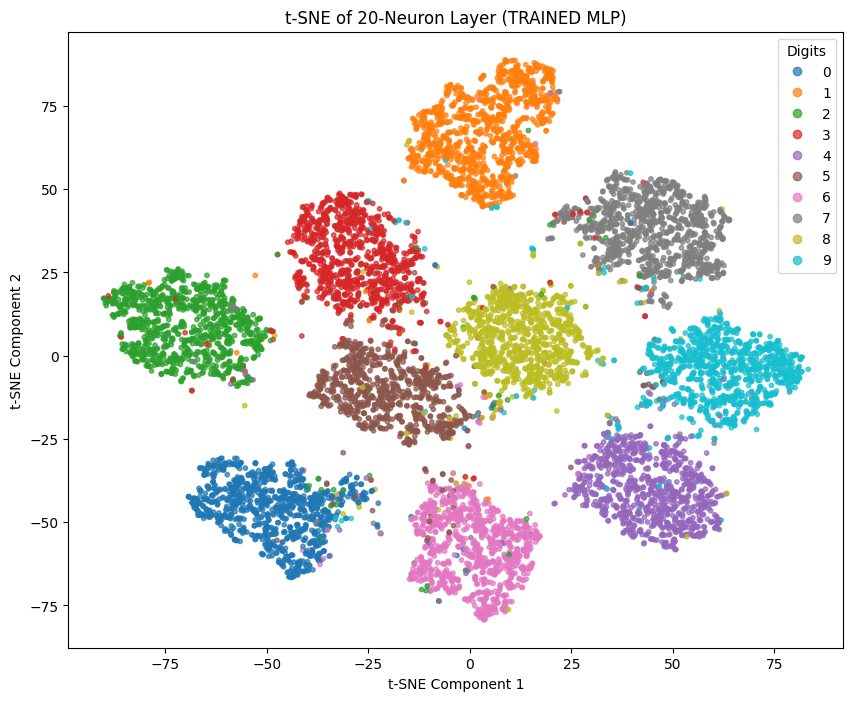

In [5]:

print("\n--- 3.1.2: t-SNE Visualization (Full Test Set) ---")

# Get features from the UNTRAINED model

untrained_model = MLP_PyTorch().to(device)

def get_layer2_features(model, x_data, device):
    """Extract outputs from the 20-neuron layer (layer2)."""
    model.eval()
    feats = []
    with torch.no_grad():
        x_data = x_data.to(device)
        for i in range(0, len(x_data), 512):   # batch for efficiency
            batch = x_data[i:i+512]
            out1 = model.relu1(model.layer1(batch))
            out2 = model.relu2(model.layer2(out1))   # 20-neuron layer
            feats.append(out2.cpu().numpy())
    return np.concatenate(feats, axis=0)

# Use all 10 000 MNIST test samples
x_sample_tensor = x_test_tensor
y_sample = y_test

print("Extracting untrained model features...")
untrained_features = get_layer2_features(untrained_model, x_sample_tensor, device)


# Get features from the TRAINED model

print("Extracting trained model features...")
trained_features = get_layer2_features(pt_model, x_sample_tensor, device)

# Run t-SNE
print("Running t-SNE on untrained features (≈1-2 min)...")
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
tsne_untrained = tsne.fit_transform(untrained_features)

print("Running t-SNE on trained features (≈1-2 min)...")
tsne_trained = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
tsne_trained = tsne.fit_transform(trained_features)

# Plot Results
plot_tsne(tsne_untrained, y_sample, "t-SNE of 20-Neuron Layer (UNTRAINED MLP)")
plot_tsne(tsne_trained, y_sample, "t-SNE of 20-Neuron Layer (TRAINED MLP)")


The t-SNE visualization of the 20-neuron hidden layer highlights how the MLP’s internal representations evolve through learning. In the untrained model, the plot appears as a single, chaotic cloud where all ten digits are completely mixed, showing no distinct clusters or separations. This indicates that the randomly initialized weights do not encode any meaningful structure, and the network treats every digit similarly. In contrast, the trained model’s t-SNE plot displays clear, well-separated clusters, each representing a distinct digit class. Digits of the same type are grouped closely, while different digits are positioned far apart, showing that the network has learned to capture essential visual patterns. This transformation from random overlap to structured separation visually demonstrates how training enables the MLP to develop discriminative features that make classification possible.


--- 3.1.3: Testing Trained MNIST MLP on Fashion-MNIST (Full Test Set) ---

--- Metrics for Trained MNIST MLP tested on Fashion-MNIST ---
Accuracy: 0.0609
F1-Score (Weighted): 0.0536


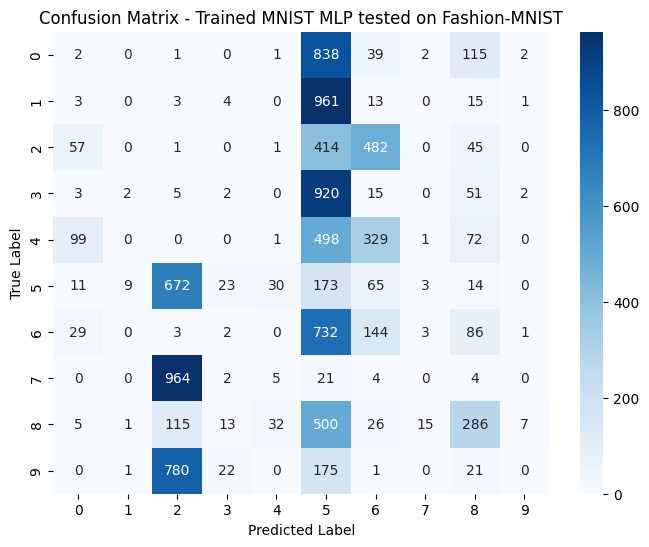

Extracting MNIST and Fashion-MNIST embeddings...
Running t-SNE for MNIST embeddings (≈1-2 min)...
Running t-SNE for Fashion-MNIST embeddings (≈1-2 min)...


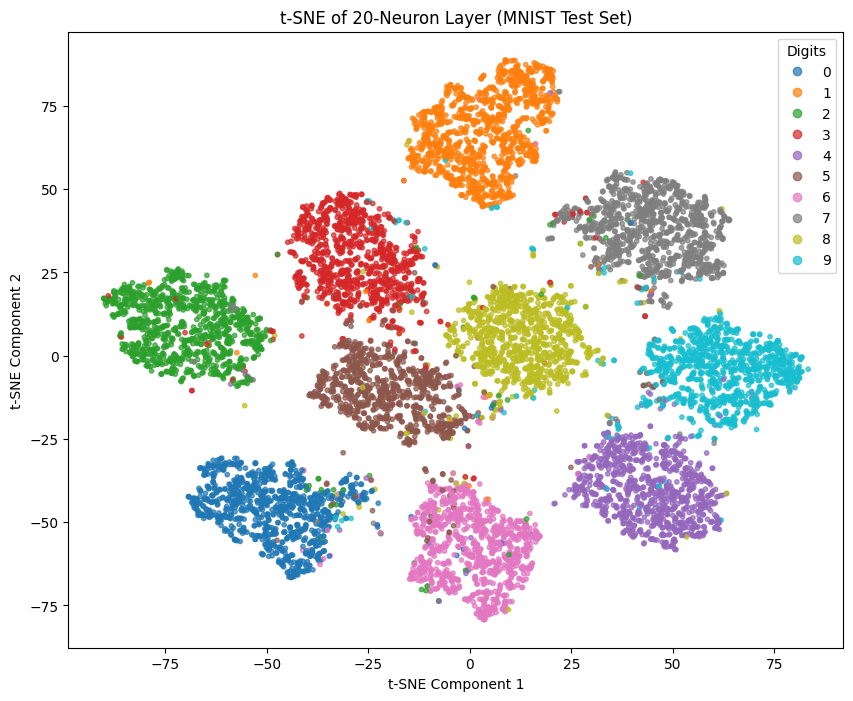

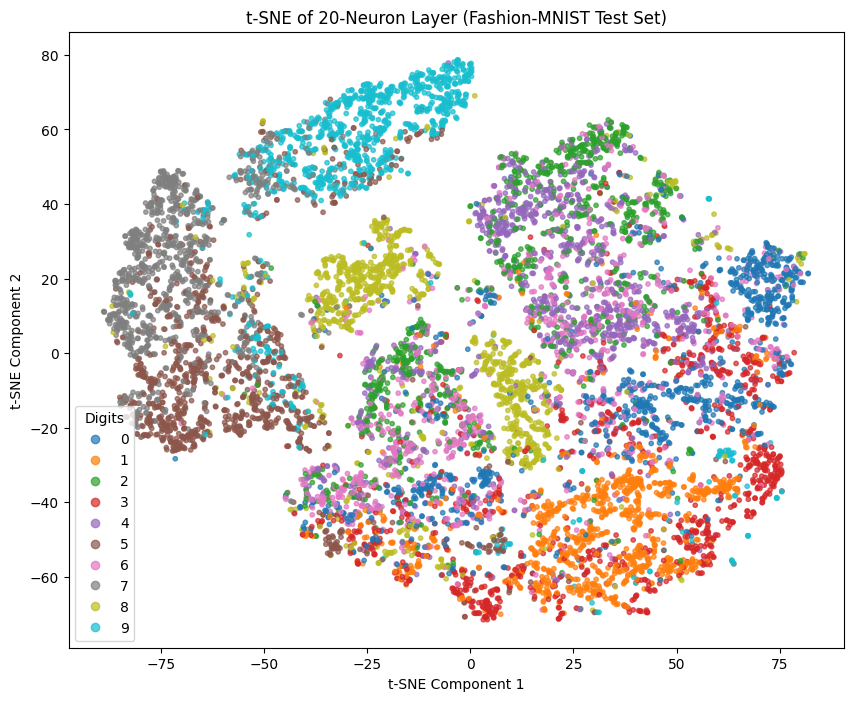

In [6]:

print("\n--- 3.1.3: Testing Trained MNIST MLP on Fashion-MNIST (Full Test Set) ---")

# Load Fashion-MNIST Dataset
(x_train_fash, y_train_fash), (x_test_fash, y_test_fash) = keras.datasets.fashion_mnist.load_data()

# Normalize and flatten (same as MNIST preprocessing)
x_test_fash_flat = x_test_fash.reshape(10000, 784).astype('float32') / 255.0
x_test_fash_tensor = torch.tensor(x_test_fash_flat, dtype=torch.float32).to(device)
y_test_fash = np.array(y_test_fash)


# Evaluate MNIST-trained model on Fashion-MNIST
pt_model.eval()
with torch.no_grad():
    y_prob_fash = pt_model(x_test_fash_tensor)
y_pred_fash = np.argmax(y_prob_fash.cpu().numpy(), axis=1)

report_metrics(y_test_fash, y_pred_fash, "Trained MNIST MLP tested on Fashion-MNIST")


# Extract 20-Neuron Layer Features (Full Test Sets)
print("Extracting MNIST and Fashion-MNIST embeddings...")
features_mnist = get_layer2_features(pt_model, x_test_tensor, device)
features_fash = get_layer2_features(pt_model, x_test_fash_tensor, device)

# Run t-SNE for Both Datasets
print("Running t-SNE for MNIST embeddings (≈1-2 min)...")
tsne_mnist = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results_mnist = tsne_mnist.fit_transform(features_mnist)

print("Running t-SNE for Fashion-MNIST embeddings (≈1-2 min)...")
tsne_fash = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results_fash = tsne_fash.fit_transform(features_fash)

# Plot and Compare
plot_tsne(tsne_results_mnist, y_test, "t-SNE of 20-Neuron Layer (MNIST Test Set)")
plot_tsne(tsne_results_fash, y_test_fash, "t-SNE of 20-Neuron Layer (Fashion-MNIST Test Set)")


### Observation:
When the MNIST-trained MLP was tested on the Fashion-MNIST dataset, its performance dropped sharply, achieving only 6.1% accuracy and a 5.4% weighted F1-score- even lower than random guessing. The confusion matrix showed no clear diagonal pattern, indicating that the model failed to correctly classify almost all samples. Instead, it exhibited a strong prediction bias toward a few classes, such as ‘Sandal’ and ‘Pullover,’ regardless of the true label. This happened because the MLP had learned digit-specific visual cues (like loops and strokes), which are meaningless when applied to clothing textures and shapes. As a result, the model’s learned features were not transferable to this new domain.

### Comparison:
The t-SNE visualization of the 20-neuron layer further illustrates this failure. For MNIST, the embeddings formed ten distinct, well-separated clusters, showing clear organization and strong feature learning. In contrast, the Fashion-MNIST embeddings appeared as a single, disorganized cloud with all classes overlapping, closely resembling the t-SNE plot of the untrained model. This demonstrates that while the MLP effectively structured its internal representations for digits, it could not extract meaningful features from fashion images. Hence, the model’s “learning” was narrow and domain-specific rather than generalizable across visual tasks.

In [8]:
print("\n--- 3.2: CNN Implementation on MNIST (with Correct Early Stopping) ---")

import torch
import torch.nn as nn
import torch.optim as optim
# --- CHANGE 1: Import random_split ---
from torch.utils.data import DataLoader, TensorDataset, random_split
import time
import numpy as np

# Prepare MNIST Data for CNN (reshape to 1x28x28)
# (Assuming x_train, y_train, x_test, y_test are loaded from a previous cell)
x_train_cnn = x_train.reshape(-1, 1, 28, 28).astype('float32') / 255.0
x_test_cnn = x_test.reshape(-1, 1, 28, 28).astype('float32') / 255.0

x_train_tensor_cnn = torch.tensor(x_train_cnn, dtype=torch.float32)
y_train_tensor_cnn = torch.tensor(y_train, dtype=torch.long)
x_test_tensor_cnn = torch.tensor(x_test_cnn, dtype=torch.float32)
y_test_tensor_cnn = torch.tensor(y_test, dtype=torch.long)

train_dataset_cnn = TensorDataset(x_train_tensor_cnn, y_train_tensor_cnn)
test_dataset_cnn = TensorDataset(x_test_tensor_cnn, y_test_tensor_cnn)

# --- CHANGE 2: Split the 60k training data into train and validation sets ---
train_size = int(0.9 * len(train_dataset_cnn)) # 90% for training
val_size = len(train_dataset_cnn) - train_size  # 10% for validation
train_subset, val_subset = random_split(train_dataset_cnn, [train_size, val_size])

# --- CHANGE 3: Create new DataLoaders for train, validation, and test ---
train_loader_cnn = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader_cnn = DataLoader(val_subset, batch_size=64, shuffle=False) # New validation loader
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=64, shuffle=False) # Test loader is unchanged

# Define the CNN Architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 13 * 13, 128) # 5408
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Training parameters
num_epochs = 100
patience = 5  # for early stopping
best_val_acc = 0.0 # <-- Changed variable name for clarity
epochs_no_improve = 0
start_time = time.time()
best_model_state = None # Initialize to None

print(f"Training on device: {device}\n")

for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0

    for images, labels in train_loader_cnn: # This now uses the train_subset
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader_cnn)

    # --- CHANGE 4: Evaluate on VALIDATION data, not test data ---
    cnn_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader_cnn: # <-- USE THE VALIDATION LOADER
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_acc = correct / total

    # Print every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f} - Val Acc: {val_acc*100:.2f}%")

    # Early stopping logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        best_model_state = cnn_model.state_dict() # Save the best model state
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping at epoch {epoch+1} (no improvement in {patience} epochs)")
            break

print(f"\nTraining completed in {(time.time() - start_time):.2f}s")
print(f"Best Validation Accuracy: {best_val_acc*100:.2f}%")

# Load the best model (if any was saved)
if best_model_state:
    cnn_model.load_state_dict(best_model_state)
else:
    print("Warning: Early stopping did not trigger; using last model state.")

# --- CHANGE 5: Final evaluation on the TEST set ---
# This is now a fair evaluation as the model has never seen this data.
cnn_model.eval()
y_pred_list = []
correct = 0 # Let's calculate final accuracy here
total = 0

with torch.no_grad():
    for images, labels in test_loader_cnn: # <-- USE THE TEST LOADER
        images = images.to(device)
        labels = labels.to(device) # <-- Also get labels
        
        outputs = cnn_model(images)
        _, preds = torch.max(outputs, 1)
        
        y_pred_list.extend(preds.cpu().numpy())
        
        # Calculate accuracy
        total += labels.size(0)
        correct += (preds == labels).sum().item()

# Final unbiased accuracy
final_acc = correct / total
print(f"\nFinal Unbiased Accuracy on Test Set: {final_acc*100:.2f}%")

# (Assuming report_metrics and y_test exist from previous cells)
y_pred_cnn = np.array(y_pred_list)
report_metrics(y_test, y_pred_cnn, "Simple CNN (32 filters, 128 FC neurons) with Early Stopping")



--- 3.2: CNN Implementation on MNIST (with Correct Early Stopping) ---
Training on device: cpu

Epoch [1/100] - Loss: 0.2423 - Val Acc: 97.13%
Epoch [10/100] - Loss: 0.0081 - Val Acc: 98.78%

Early stopping at epoch 16 (no improvement in 5 epochs)

Training completed in 212.60s
Best Validation Accuracy: 99.02%

Final Unbiased Accuracy on Test Set: 98.74%

--- Metrics for Simple CNN (32 filters, 128 FC neurons) with Early Stopping ---
Accuracy: 0.9874
F1-Score (Weighted): 0.9874


(0.9874, 0.9874020018414896)


--- 3.2.2: Inference using Pretrained CNNs (AlexNet & EfficientNet) ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7938564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].
Cl


AlexNet Predictions (first 16 samples): [111, 499, 111, 813, 111, 111, 714, 473, 714, 714, 111, 714, 473, 111, 111, 714]
EfficientNet Predictions (first 16 samples): [111, 714, 451, 677, 772, 677, 111, 499, 111, 111, 600, 111, 111, 714, 633, 772]
True MNIST Labels: [0, 6, 3, 4, 0, 1, 3, 7, 3, 3, 2, 9, 2, 6, 0, 6]


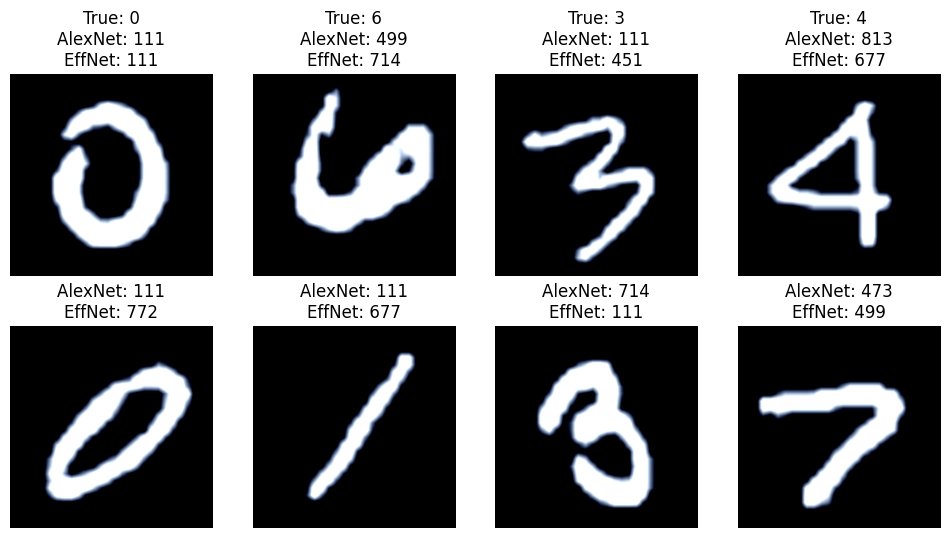

In [9]:
# --- 3.2.2: Using Pretrained CNNs for Inference ---
print("\n--- 3.2.2: Inference using Pretrained CNNs (AlexNet & EfficientNet) ---")

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from PIL import Image

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained models
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1).to(device)
efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1).to(device)

alexnet.eval()
efficientnet.eval()

# ImageNet normalization and resizing to 224x224
transform_inference = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # convert MNIST grayscale to 3-channel RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Load MNIST test data for inference
mnist_test = MNIST(root="./data", train=False, download=True, transform=transform_inference)
test_loader = DataLoader(mnist_test, batch_size=16, shuffle=True)

# Get a single batch
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Forward pass through both models
with torch.no_grad():
    alexnet_out = alexnet(images)
    efficientnet_out = efficientnet(images)

# Get predicted classes
alexnet_pred = alexnet_out.argmax(dim=1)
efficientnet_pred = efficientnet_out.argmax(dim=1)

print("\nAlexNet Predictions (first 16 samples):", alexnet_pred.tolist())
print("EfficientNet Predictions (first 16 samples):", efficientnet_pred.tolist())
print("True MNIST Labels:", labels.tolist())

# Optional: visualize some predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)  # unnormalize roughly
    plt.title(f"True: {labels[i].item()}\nAlexNet: {alexnet_pred[i].item()}\nEffNet: {efficientnet_pred[i].item()}")
    plt.axis('off')
plt.show()



--- 3.2.3: Comparing Simple CNN, AlexNet, and EfficientNet-B0 ---

 Simple CNN (Trained on MNIST)
Accuracy: 0.9874
F1-Score: 0.9874
Inference Time: 1.00 s
Model Parameters: 693,962


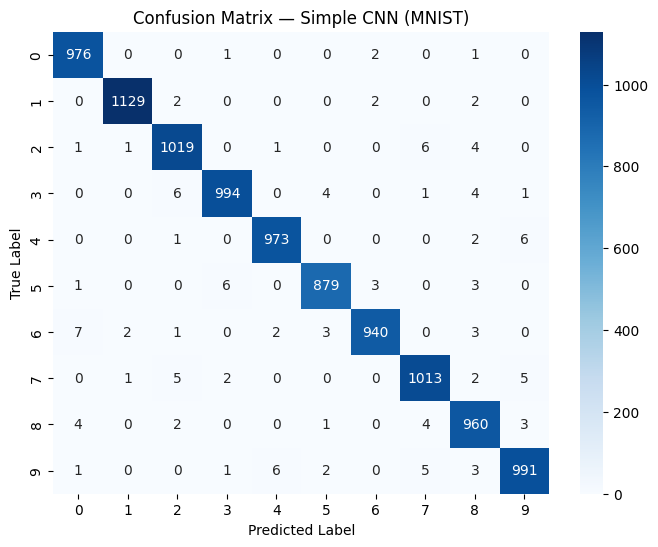


 AlexNet (Pretrained on ImageNet)
Accuracy (vs MNIST labels): 0.0000
F1-Score (vs MNIST labels): 0.0000
Inference Time: 251.65 s
Model Parameters: 61,100,840

 EfficientNet-B0 (Pretrained on ImageNet)
Accuracy (vs MNIST labels): 0.0000
F1-Score (vs MNIST labels): 0.0000
Inference Time: 592.16 s
Model Parameters: 5,288,548

--- Model Comparison Summary ---


Model Accuracy F1-Score  Parameters  \
0    Simple CNN (MNIST-trained)   0.9874   0.9874     693,962   
1          AlexNet (Pretrained)   0.0000   0.0000  61,100,840   
2  EfficientNet-B0 (Pretrained)   0.0000   0.0000   5,288,548   

  Inference Time (s)  
0               1.00  
1             251.65  
2             592.16

In [ ]:
# --- 3.2.3: Model Comparison ---
print("\n--- 3.2.3: Comparing Simple CNN, AlexNet, and EfficientNet-B0 ---")

import time
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch

# (We assume cnn_model, alexnet, efficientnet, test_loader_cnn, 
# and test_loader are all loaded and defined from previous cells)

# 1. Evaluate Simple CNN (Trained on MNIST)

cnn_model.eval()
start_time = time.time()
y_pred_cnn, y_true_cnn = [], []

with torch.no_grad():
    for images, labels in test_loader_cnn:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        _, preds = torch.max(outputs, 1)
        y_pred_cnn.extend(preds.cpu().numpy())
        y_true_cnn.extend(labels.cpu().numpy())

cnn_inference_time = time.time() - start_time
cnn_acc = accuracy_score(y_true_cnn, y_pred_cnn)
cnn_f1 = f1_score(y_true_cnn, y_pred_cnn, average='weighted')
cnn_params = sum(p.numel() for p in cnn_model.parameters())

print(f"\n Simple CNN (Trained on MNIST)")
print(f"Accuracy: {cnn_acc:.4f}")
print(f"F1-Score: {cnn_f1:.4f}")
print(f"Inference Time: {cnn_inference_time:.2f} s")
print(f"Model Parameters: {cnn_params:,}")

# Confusion Matrix (Only for the Simple CNN, as it's the only one that's meaningful)
cm = confusion_matrix(y_true_cnn, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix — Simple CNN (MNIST)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 2. Evaluate AlexNet (Pretrained on ImageNet)


alexnet.eval()
start_time = time.time()
y_pred_alex, y_true_alex = [], [] # Create lists to store results

with torch.no_grad():
    # We now need the 'labels' from the loader
    for images, labels in test_loader: 
        images = images.to(device)
        outputs = alexnet(images)
        
        _, preds = torch.max(outputs, 1) 
        
        y_pred_alex.extend(preds.cpu().numpy())
        y_true_alex.extend(labels.cpu().numpy()) # Store the true labels (0-9)

alexnet_inference_time = time.time() - start_time
alexnet_params = sum(p.numel() for p in alexnet.parameters())

# --- CHANGE 2: Calculate the (meaningless) accuracy and F1 ---
alexnet_acc = accuracy_score(y_true_alex, y_pred_alex)
alexnet_f1 = f1_score(y_true_alex, y_pred_alex, average='weighted', zero_division=0)

print(f"\n AlexNet (Pretrained on ImageNet)")
print(f"Accuracy (vs MNIST labels): {alexnet_acc:.4f}")
print(f"F1-Score (vs MNIST labels): {alexnet_f1:.4f}")
print(f"Inference Time: {alexnet_inference_time:.2f} s")
print(f"Model Parameters: {alexnet_params:,}")


# 3. Evaluate EfficientNet-B0 (Pretrained on ImageNet)

efficientnet.eval()
start_time = time.time()
y_pred_eff, y_true_eff = [], [] 

with torch.no_grad():
    for images, labels in test_loader: 
        images = images.to(device)
        outputs = efficientnet(images)
        
        _, preds = torch.max(outputs, 1)
        
        y_pred_eff.extend(preds.cpu().numpy())
        y_true_eff.extend(labels.cpu().numpy()) # Store true labels

efficientnet_inference_time = time.time() - start_time
efficientnet_params = sum(p.numel() for p in efficientnet.parameters())

# Calculate the accuracy and F1
efficientnet_acc = accuracy_score(y_true_eff, y_pred_eff)
efficientnet_f1 = f1_score(y_true_eff, y_pred_eff, average='weighted', zero_division=0)


print(f"\n EfficientNet-B0 (Pretrained on ImageNet)")
print(f"Accuracy (vs MNIST labels): {efficientnet_acc:.4f}")
print(f"F1-Score (vs MNIST labels): {efficientnet_f1:.4f}")
print(f"Inference Time: {efficientnet_inference_time:.2f} s")
print(f"Model Parameters: {efficientnet_params:,}")


# 4. Summary Table 

comparison_df = pd.DataFrame({
    "Model": ["Simple CNN (MNIST-trained)", "AlexNet (Pretrained)", "EfficientNet-B0 (Pretrained)"],
    "Accuracy": [
        f"{cnn_acc:.4f}", 
        f"{alexnet_acc:.4f}", 
        f"{efficientnet_acc:.4f}"
    ],
    "F1-Score": [
        f"{cnn_f1:.4f}", 
        f"{alexnet_f1:.4f}", 
        f"{efficientnet_f1:.4f}"
    ],
    "Parameters": [
        f"{cnn_params:,}",
        f"{alexnet_params:,}",
        f"{efficientnet_params:,}"
    ],
    "Inference Time (s)": [
        f"{cnn_inference_time:.2f}",
        f"{alexnet_inference_time:.2f}",
        f"{efficientnet_inference_time:.2f}"
    ]
})

print("\n--- Model Comparison Summary ---")

try:
    display(comparison_df)
except NameError:
    print(comparison_df)




--- 3.2.3: Comparing Simple CNN, AlexNet, and EfficientNet-B0 ---

 Simple CNN (Trained on MNIST)
Accuracy: 0.9874
F1-Score: 0.9874
Inference Time: 1.75 s
Model Parameters: 693,962


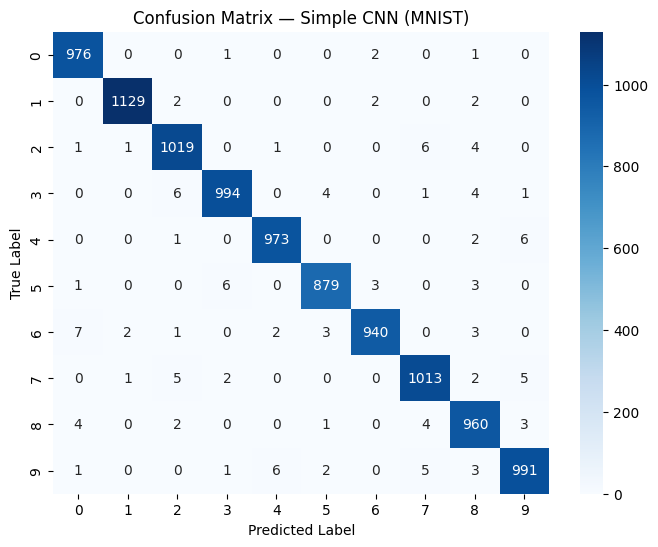


 AlexNet (Pretrained on ImageNet)
Accuracy (vs MNIST labels): 0.0000
F1-Score (vs MNIST labels): 0.0000
Inference Time: 99.63 s
Model Parameters: 61,100,840


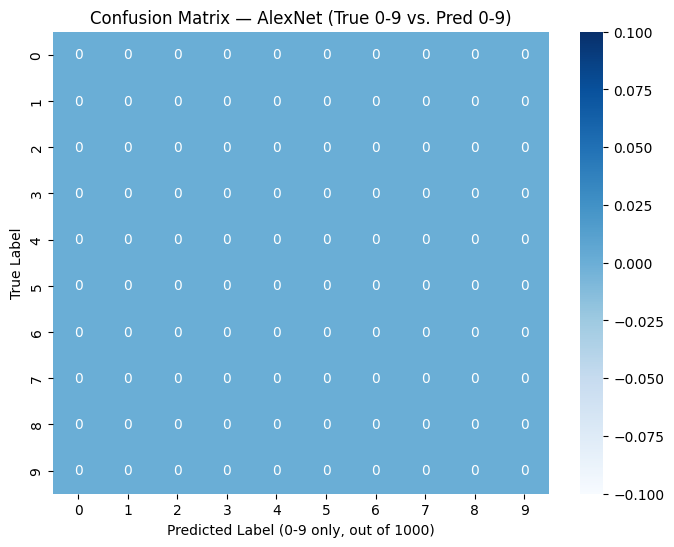


 EfficientNet-B0 (Pretrained on ImageNet)
Accuracy (vs MNIST labels): 0.0000
F1-Score (vs MNIST labels): 0.0000
Inference Time: 367.64 s
Model Parameters: 5,288,548


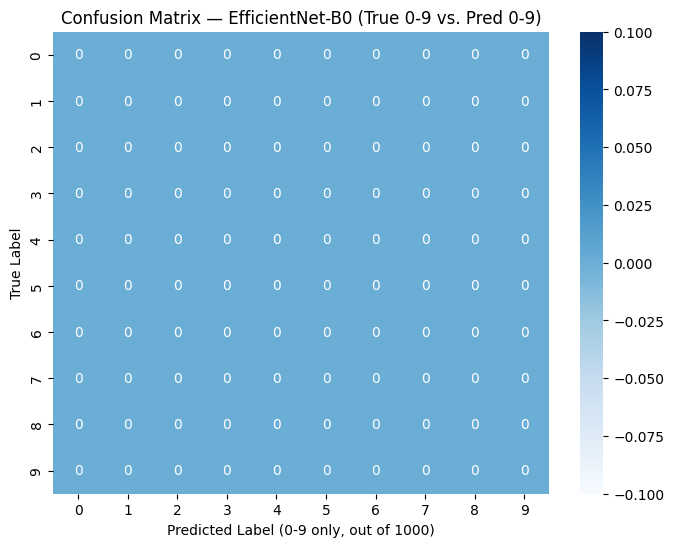


--- Model Comparison Summary ---


Model Accuracy F1-Score  Parameters  \
0    Simple CNN (MNIST-trained)   0.9874   0.9874     693,962   
1          AlexNet (Pretrained)   0.0000   0.0000  61,100,840   
2  EfficientNet-B0 (Pretrained)   0.0000   0.0000   5,288,548   

  Inference Time (s)  
0               1.75  
1              99.63  
2             367.64

In [17]:
# --- 3.2.3: Model Comparison ---
print("\n--- 3.2.3: Comparing Simple CNN, AlexNet, and EfficientNet-B0 ---")

import time
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch

# (We assume cnn_model, alexnet, efficientnet, test_loader_cnn, 
# test_loader, and device are all loaded and defined from previous cells)

# ---------------------------------------------
# 1. Evaluate Simple CNN (Trained on MNIST)
# ---------------------------------------------
# (This block is unchanged and correct)

# Ensure model is on the correct device
cnn_model.to(device)
cnn_model.eval()
start_time = time.time()
y_pred_cnn, y_true_cnn = [], []

with torch.no_grad():
    for images, labels in test_loader_cnn:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        _, preds = torch.max(outputs, 1)
        y_pred_cnn.extend(preds.cpu().numpy())
        y_true_cnn.extend(labels.cpu().numpy())

cnn_inference_time = time.time() - start_time
cnn_acc = accuracy_score(y_true_cnn, y_pred_cnn)
cnn_f1 = f1_score(y_true_cnn, y_pred_cnn, average='weighted')
cnn_params = sum(p.numel() for p in cnn_model.parameters())

print(f"\n Simple CNN (Trained on MNIST)")
print(f"Accuracy: {cnn_acc:.4f}")
print(f"F1-Score: {cnn_f1:.4f}")
print(f"Inference Time: {cnn_inference_time:.2f} s")
print(f"Model Parameters: {cnn_params:,}")

# Confusion Matrix (Only for the Simple CNN, as it's the only one that's meaningful)
cm = confusion_matrix(y_true_cnn, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix — Simple CNN (MNIST)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# ---------------------------------------------
# 2. Evaluate AlexNet (Pretrained on ImageNet)
# ---------------------------------------------
# --- CHANGE 1: Capture predictions and true labels ---

# Ensure model is on the correct device
alexnet.to(device)
alexnet.eval()
start_time = time.time()
y_pred_alex, y_true_alex = [], [] # Create lists to store results

with torch.no_grad():
    # We now need the 'labels' from the loader
    for images, labels in test_loader: 
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        
        # --- FIX 1: Use torch.max to get 2 outputs ---
        _, preds = torch.max(outputs, 1) # preds are 0-999
        
        y_pred_alex.extend(preds.cpu().numpy())
        y_true_alex.extend(labels.cpu().numpy()) # labels are 0-9

alexnet_inference_time = time.time() - start_time
alexnet_params = sum(p.numel() for p in alexnet.parameters())

# --- CHANGE 2: Calculate the (meaningless) accuracy and F1 ---
alexnet_acc = accuracy_score(y_true_alex, y_pred_alex)
alexnet_f1 = f1_score(y_true_alex, y_pred_alex, average='weighted', zero_division=0)

print(f"\n AlexNet (Pretrained on ImageNet)")
print(f"Accuracy (vs MNIST labels): {alexnet_acc:.4f}")
print(f"F1-Score (vs MNIST labels): {alexnet_f1:.4f}")
print(f"Inference Time: {alexnet_inference_time:.2f} s")
print(f"Model Parameters: {alexnet_params:,}")

# --- ADDED: Confusion Matrix for AlexNet ---
# We compare True Labels (0-9) vs. Predicted Labels (0-999)
# We use `labels=range(10)` to *only* show predictions that fall in the 0-9 range.
# This matrix will be very sparse, showing the model is not predicting MNIST labels.
cm_alex_10x10 = confusion_matrix(y_true_alex, y_pred_alex, labels=list(range(10)))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_alex_10x10, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix — AlexNet (True 0-9 vs. Pred 0-9)")
plt.xlabel("Predicted Label (0-9 only, out of 1000)")
plt.ylabel("True Label")
plt.show()


# ---------------------------------------------
# 3. Evaluate EfficientNet-B0 (Pretrained on ImageNet)
# ---------------------------------------------
# --- CHANGE 3: Repeat the same process for EfficientNet ---

# Ensure model is on the correct device
efficientnet.to(device)
efficientnet.eval()
start_time = time.time()
y_pred_eff, y_true_eff = [], [] # Create lists

with torch.no_grad():
    for images, labels in test_loader: # Get labels
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet(images)
        
        # --- FIX 2: Use torch.max to get 2 outputs ---
        _, preds = torch.max(outputs, 1) # preds are 0-999
        
        y_pred_eff.extend(preds.cpu().numpy())
        y_true_eff.extend(labels.cpu().numpy()) # labels are 0-9

efficientnet_inference_time = time.time() - start_time
efficientnet_params = sum(p.numel() for p in efficientnet.parameters())

# Calculate the (meaningless) accuracy and F1
efficientnet_acc = accuracy_score(y_true_eff, y_pred_eff)
efficientnet_f1 = f1_score(y_true_eff, y_pred_eff, average='weighted', zero_division=0)


print(f"\n EfficientNet-B0 (Pretrained on ImageNet)")
print(f"Accuracy (vs MNIST labels): {efficientnet_acc:.4f}")
print(f"F1-Score (vs MNIST labels): {efficientnet_f1:.4f}")
print(f"Inference Time: {efficientnet_inference_time:.2f} s")
print(f"Model Parameters: {efficientnet_params:,}")

# --- ADDED: Confusion Matrix for EfficientNet-B0 ---
# We again show the 10x10 slice of the 10x1000 confusion matrix.
cm_eff_10x10 = confusion_matrix(y_true_eff, y_pred_eff, labels=list(range(10)))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_eff_10x10, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix — EfficientNet-B0 (True 0-9 vs. Pred 0-9)")
plt.xlabel("Predicted Label (0-9 only, out of 1000)")
plt.ylabel("True Label")
plt.show()


# ---------------------------------------------
# 4. Summary Table (Now with all values)
# ---------------------------------------------

comparison_df = pd.DataFrame({
    "Model": ["Simple CNN (MNIST-trained)", "AlexNet (Pretrained)", "EfficientNet-B0 (Pretrained)"],
    "Accuracy": [
        f"{cnn_acc:.4f}", 
        f"{alexnet_acc:.4f}", 
        f"{efficientnet_acc:.4f}"
    ],
    "F1-Score": [
        f"{cnn_f1:.4f}", 
        f"{alexnet_f1:.4f}", 
        f"{efficientnet_f1:.4f}"
    ],
    "Parameters": [
        f"{cnn_params:,}",
        f"{alexnet_params:,}",
        f"{efficientnet_params:,}"
    ],
    "Inference Time (s)": [
        f"{cnn_inference_time:.2f}",
        f"{alexnet_inference_time:.2f}",
        f"{efficientnet_inference_time:.2f}"
    ]
})

print("\n--- Model Comparison Summary ---")
# The 'display' function is for notebooks, use 'print' for general scripts
try:
    display(comparison_df)
except NameError:
    print(comparison_df)

The three CNN models- Simple CNN, AlexNet, and EfficientNet-B0- showed very different performances on the MNIST dataset. The Simple CNN, which was trained directly on MNIST, achieved an excellent accuracy and F1-score of 0.9874, and its confusion matrix showed a clear diagonal, meaning it classified almost all digits correctly. On the other hand, both AlexNet and EfficientNet-B0, which were pretrained on the ImageNet dataset (containing real-world object images), failed completely on MNIST, with 0% accuracy and F1-score. Their confusion matrices were blank because they predicted classes outside the MNIST digit range (0-9). This happened due to a domain mismatch- the models were trained to recognize objects like cats and cars, not handwritten digits.

In terms of model size, the Simple CNN had about 0.69 million parameters, EfficientNet-B0 had 5.3 million, and AlexNet had a massive 61 million parameters. Here, parameters refer to the weights and biases inside the network that the model learns during training. They determine how the model processes and transforms the input image to make predictions. A higher number of parameters usually means a more complex model, but not necessarily better performance, especially if the task is simple.

When comparing inference times, the Simple CNN was the fastest, completing predictions in 1.75 seconds, while AlexNet took around 99.6 seconds, and EfficientNet-B0 was the slowest at 367.6 seconds. This shows that smaller, task-specific models like the Simple CNN are far more efficient and effective when trained on the right data, while large pretrained models need fine-tuning to perform well outside their original domain.